# CS 224U Final Project: Relation Extraction with Graph Embeddings

**Authors:** Ben Barnett and Aakash Pattabi

In [81]:
import numpy as np
import json
import sys
from pycorenlp import StanfordCoreNLP
from collections import defaultdict
import subprocess
import sys
import random
import pandas as pd
import pickle
import os

### 1. Loading TACRED data

In [82]:
train_path = "tacred/data/json/train.json"
eval_path = "tacred/data/json/dev.json"
test_path = "tacred/data/json/test.json"

with open(train_path, "rb") as f:
    train_data = json.load(f)
    
with open(eval_path, "rb") as f:
    eval_data = json.load(f)
    
with open(test_path, "rb") as f:
    test_data = json.load(f)

In [183]:
print("{} training samples".format(len(train_data)))
print("{} dev samples".format(len(eval_data)))
print("{} test samples".format(len(test_data)))

68124 training samples
22631 dev samples
15509 test samples


### 2. Defining a sentence-level feature extractor

In [184]:
class GraphFeatureExtractor(object):
    def __init__(self, server, parse_level = "basic", 
                 embedding_path = None):
        self.server = server
        self.set_parse_level(parse_level)
        
        # Initialize word embeddings
        if embedding_path:
            self.embedding_path = embedding_path
            self._load_embeddings()
        else:
            self.embedding_path = None
            
        self._reset_class_distribution()
        self._reset_class_labels()
    
    def _reset_class_labels(self):
        self.class_labels = {}
    
    def _reset_class_distribution(self):
        self.class_distribution = defaultdict(int)
        self.sentences_seen = 0
        
    def _load_embeddings(self):
        self.embeddings = {}
        with open(self.embedding_path, "r", encoding = "utf-8") as f:
            for line in f:
                tokens = line.split()
                self.embeddings[tokens[0]] = [float(i) for i in tokens[1:]]
    
    def get_class_labels(self):
        return self.class_labels
    
    def set_parse_level(self, parse_level):
        assert parse_level in ["basic", "enhanced", "extra_enhanced"]
        d = {
            "basic" : "basicDependencies",
            "enhanced" : "enhancedDependencies", 
            "extra_enhanced" : "enhancedPlusPlusDependencies"
        }
        self.parse_level = d[parse_level]
    
    def _extract_graph(self, sentence):
        Y = sentence["relation"]
        self.class_distribution[Y] += 1
        self.sentences_seen += 1
        if Y not in self.class_labels:
            self.class_labels[Y] = len(self.class_labels)
        
        # Extract tokens, subsentence (b/w subj->obj tokens)
        tokens = sentence["token"]
        first = min(sentence["subj_start"], sentence["obj_start"])
        second = max(sentence["subj_end"], sentence["obj_end"])
        middle = tokens[first:second+1]

        # Concatenate full sentence and sentence middle (b/w subj->obj tokens)
        full_sentence = " ".join(tokens)
        full_middle = " ".join(middle)
        
        # Parse with Stanford parser
        full_sentence_out = server.annotate(full_sentence, properties = {
            "annotators" : "parse", 
            "outputFormat" : "json"
        })
        middle_out = server.annotate(full_middle, properties = {
            "annotators" : "parse", 
            "outputFormat" : "json"
        })
        
        # Extract graph edgelist
        X_full, full_tokens = self._parse_to_graph(full_sentence_out)
        X_middle, middle_tokens = self._parse_to_graph(middle_out)
        
        # Add word-level GloVe features to graph inputs
        if self.embedding_path:
            X_full["features"] = self._get_embedding_features(full_tokens)
            for k in set().union(*X_full["edges"]): # Error-checking to make sure G2V completes
                assert k in X_full["features"]
            
            X_middle["features"] = self._get_embedding_features(middle_tokens)
            for k in set().union(*X_middle["edges"]): # Error-checking to make sure G2V completes
                assert k in X_middle["features"]
        
        return {"full" : X_full, "middle" : X_middle, "Y" : Y}
        
    def _parse_to_graph(self, parse):                        
        dep_list = parse["sentences"][0][self.parse_level]
        dep_graph = defaultdict(lambda : [])
        for d in dep_list:
                dep_graph[d["governor"]].append(d["dependent"])
        
        parser_tokens = [tok["word"] for tok in parse["sentences"][0]["tokens"]]
        return self._convert_to_edgelist(dep_graph), parser_tokens
    
    def _convert_to_edgelist(self, dep_graph):
        el = {
            "edges" : [[k, vi] for k, v in dep_graph.items() for vi in v] 
        }        
        return el
    
    def _get_embedding_features(self, sent, embedding_dim = 50):
        feats = {}
        for i, token in enumerate(sent):
            features = self.embeddings.get(token, None)
            if not features:
                features = [np.random.rand() for j in range(embedding_dim)]
            feats[i+1] = features
            
        # By default, we assign the [ROOT] token in the parse tree an embedding vector
        # of all zeroes... mostly because I'm not strictly sure what else to do here. @Ben, thoughts?
        feats[0] = [0]*embedding_dim
        return feats
    
    def extract_batch_graphs(self, sentences):
        n_sentences = len(sentences)
        batch = []
        for i, s in enumerate(sentences):
            batch.append(self._extract_graph(s))
            print("Extracted graphs for [{}/{}] sentences...".format(i+1, n_sentences), end = "\r")
            sys.stdout.flush()

        return batch
    
    def extract_resampled_graphs(self, features, total):
        n_to_resample = total - len(features)
        if n_to_resample <= 0:
            return
        
        resampled_features = []
        while n_to_resample > 0:
            feat = random.choice(features)
            rel = feat["Y"]
            frequency = self.class_distribution[rel]/self.sentences_seen
            keep = (np.random.rand() > frequency)
            if keep:
                resampled_features.append(feat)
                n_to_resample -= 1
        return resampled_features
    
    def save_jsons(self, graphs, save_path):
        assert save_path and save_path[-1] == "/"
        for i, g in enumerate(graphs):
            with open(save_path + str(i) + ".json", "w") as f:
                json.dump(g, f)
    
    def concat_with_mean_embedding(self, features, embedding_dicts):
        n, d = features.shape
        mean_embeddings = []
        for i in range(n):
            mean_embeddings.append(np.mean([v for k, v in embedding_dicts[i].items()], axis = 0))
        return np.concatenate((features, mean_embeddings), axis = 1)
    
    def concat_with_sum_embedding(self, features, embedding_dicts):
        n, d = features.shape
        sum_embeddings = []
        for i in range(n):
            sum_embeddings.append(np.sum([v for k, v in embedding_dicts[i].items()], axis = 0))
        return np.concatenate((features, sum_embeddings), axis = 1)

Additional features to implement:
1. ~~Resampling of the original data to augment data size + reduce class imbalance that *doesn't* duplicate Graph2Vec features across repeated samples.~~
2. ~~Creating a full TAC dataset-to-features pipeline that can be deployed on arbitrary data~~ 
3. Incorporation of e.g. parse tree label information into the features. 
4. ~~Classifiers - implement logistic regression, set up as a neural network.~~

### 3. Defining a full feature-extraction pipeline that can be used on arbitrary data

In [187]:
class FeatureExtractorPipeline(object):
    def __init__(self, fe_args, save_paths):
        self.fe = GraphFeatureExtractor(**fe_args)
        self.save_paths = save_paths
        self.class_labels = None
    
    def _one_hot(self, length, hot):
        a = np.zeros(length)
        a[hot] = 1
        return a
    
    def _extract_training_graphs(self, sentences, total, train_flag):
        feats = self.fe.extract_batch_graphs(sentences)
        if total > len(sentences):
            resampled_feats = self.fe.extract_resampled_graphs(feats, total)
            feats += resampled_feats
            assert len(feats) == total    
        
        self.fe.save_jsons(
            [feat["full"] for feat in feats], 
            self.save_paths[train_flag + "_full_save_path"]
        )
        self.fe.save_jsons(
            [feat["middle"] for feat in feats], 
            self.save_paths[train_flag + "_middle_save_path"]
        )
        
        self.class_labels = self.fe.get_class_labels()
        n_classes = len(self.class_labels)
        Y = [self._one_hot(n_classes, self.class_labels[feat["Y"]]) for feat in feats]
        X_full_embs = [feat["full"]["features"] for feat in feats]
        X_middle_embs = [feat["middle"]["features"] for feat in feats]
        
        return Y, X_full_embs, X_middle_embs
    
    def _extract_training_embeddings(self, 
                                     X_full_embs, X_middle_embs,
                                     train_flag, 
                                     concat = "mean"):
        assert concat in ["mean", "sum", "both"]
        
        success_full = subprocess.call(
            ["python", 
             "graph2vec/src/graph2vec.py", 
             "--input-path", self.save_paths[train_flag + "_full_save_path"], 
             "--output-path", self.save_paths[train_flag + "_full_g2v_path"]]
        )
        assert success_full == 0
        
        success_middle = subprocess.call(
            ["python", 
             "graph2vec/src/graph2vec.py", 
             "--input-path", self.save_paths[train_flag + "_middle_save_path"], 
             "--output-path", self.save_paths[train_flag + "_middle_g2v_path"]]
        )
        assert success_middle == 0
        
        X_full = pd.read_csv(
            self.save_paths[train_flag + "_full_g2v_path"], sep = ",").drop(labels = ["type"], axis = 1)
        X_full = np.array(X_full)
        
        X_middle = pd.read_csv(
            self.save_paths[train_flag + "_middle_g2v_path"], sep = ",").drop(labels = ["type"], axis = 1)
        X_middle = np.array(X_middle)
        
        if concat == "mean" or concat == "both":
            X_full = self.fe.concat_with_mean_embedding(X_full, X_full_embs)
            X_middle = self.fe.concat_with_mean_embedding(X_middle, X_middle_embs)
        elif concat == "sum" or concat == "both":
            X_full = self.fe.concat_with_sum_embedding(X_full, X_full_embs)
            X_middle = self.fe.concat_with_sum_embedding(X_middle, X_middle_embs)
        
        return X_full, X_middle
    
    def get_class_labels(self):
        return self.class_labels
    
    def extract_features(self, sentences, total = 0, 
                         train_flag = "train", concat = "mean"):
        assert train_flag in ["train", "test", "eval"]
        
        print("Building graphs from sentence dependency trees...")
        Y, X_full_embs, X_middle_embs = self._extract_training_graphs(sentences, total, train_flag)
        np.save(self.save_paths["responses"] + train_flag, Y)
        print("Resampled sentence graphs up to {} total examples in the data...".format(len(Y)), end = "\r")
            
        print("Extracting Graph2Vec embeddings and annotationg w/ GloVe vecs...")
        X_full, X_middle = self._extract_training_embeddings(X_full_embs, X_middle_embs, train_flag, concat)
        X = np.concatenate((X_full, X_middle), axis = 1)
        np.save(self.save_paths["features"] + train_flag, X)
        print("Done!")
        return Y, X_full, X_middle

In [188]:
sanity_check = train_data[:50]
server = StanfordCoreNLP('http://localhost:9000')
embedding_path = "./glove/glove.6B.50d.txt"

fe_args = {
    "server" : server, 
    "embedding_path" : embedding_path
}

save_paths = {
    "train_full_save_path" : "train_features_full/", 
    "train_middle_save_path" : "train_features_middle/",
    "test_full_save_path" : "test_features_full/",
    "test_middle_save_path" : "test_features_middle/",
    "train_full_g2v_path" : "train_features_full_g2v/features.csv",
    "train_middle_g2v_path" : "train_features_middle_g2v/features.csv",
    "test_full_g2v_path" : "test_features_full_g2v/features.csv", 
    "test_middle_g2v_path" : "test_features_middle_g2v/features.csv",
    "responses" : "all_features/responses",
    "features" : "all_features/features"
}

n_samples = len(sanity_check)
print("Originally {} samples in training data...".format(n_samples))
fep = FeatureExtractorPipeline(fe_args, save_paths)
Y, X_full, X_middle = fep.extract_features(sanity_check, total = 100)

Originally 50 samples in training data...
Building graphs from sentence dependency trees...
Extracting Graph2Vec embeddings and annotationg w/ GloVe vecs....
Done!


Let's just verify really quickly that:
1. The one-hot encoding of the labels is correct. 
2. Resampling _did_ fix any class-imbalance issues (if there were any)...

Sentence: Christine Egerszegi-Obrist -LRB- l -RRB- and Haddad-Adel
Label: no_relation
FEP label: no_relation
# classes: 10
{0: 'org:founded_by', 1: 'no_relation', 2: 'per:employee_of', 3: 'org:alternate_names', 4: 'per:cities_of_residence', 5: 'per:children', 6: 'per:title', 7: 'per:siblings', 8: 'per:religion', 9: 'per:age'}


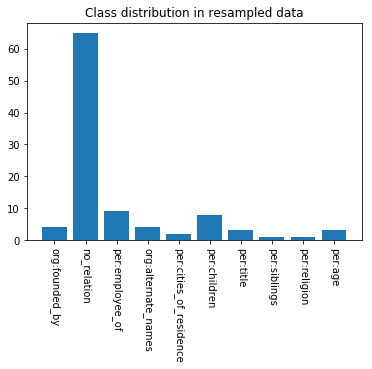

(100, 10)
(100, 178)
(100, 178)


In [189]:
import matplotlib.pyplot as plt

# Verifying that the labels are correct
idx = random.choice(range(len(sanity_check)))
ex = " ".join(sanity_check[idx]["token"])
label = sanity_check[idx]["relation"]
print("Sentence: {}\nLabel: {}".format(ex, label))

class_labels = { v : k for k, v in fep.get_class_labels().items()}
fep_label = class_labels[np.argmax(Y[idx]).astype(int)]
print("FEP label: {}".format(fep_label))
assert fep_label == label

print("# classes: {}".format(len(class_labels)))
print(class_labels)
# Verifying class-imbalance issues
labels = np.argmax(Y, axis = 1)
keys, counts = np.unique(labels, return_counts = True)
plt.bar(keys, counts)
plt.title("Class distribution in resampled data")
plt.xticks(keys, [class_labels[k] for k in keys], rotation = 270)
plt.show()

# Verifying that all the shapes work out...
print(np.array(Y).shape)
print(X_full.shape)
print(X_middle.shape)

### 4. Defining the model

In [190]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

class FullyConnectedNN(nn.Module):
    def __init__(self, architecture, input_size, output_size):
        super().__init__()
        architecture = [input_size] + architecture
        self.layers = nn.ModuleList()
        for i, neurons in enumerate(architecture[:-1]):
            self.layers.append(nn.Linear(architecture[i], architecture[i+1]))
        self.output_layer = nn.Linear(architecture[-1], output_size)
        
    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x))
        return self.output_layer(x)

Let's sanity-check just to make sure the network's forward pass is functional...

In [191]:
net = FullyConnectedNN([5, 5, 5], 10, 2)
x = torch.rand(10).view(1, -1)
y = net(x)
print(y)

tensor([[-0.0621, -0.1771]], grad_fn=<AddmmBackward>)


Finally, we write the training loop...

In [215]:
from tensorboardX import SummaryWriter

class RelExtDataset(Dataset):
    def __init__(self, X_path, Y_path, device):
        self.X = torch.from_numpy(np.load(X_path)).float().to(device)
        self.Y = torch.from_numpy(np.load(Y_path)).float().to(device)
        assert len(self.X) == len(self.Y)
        
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    
    def __len__(self):
        return len(self.Y)
    
class Trainer(object):
    def __init__(self, model, optimizer, hyperparams, device):
        self.device = device
        self.model = model.to(self.device)
        self.hyperparams = hyperparams
        self.lossfn = self.hyperparams["loss_function"]
        self.optimizer = optimizer(self.model.parameters(), lr = self.hyperparams["lr"])
        self.dataset = None
        self.epochs_trained = 0
    
    def load_data(self, X_path, Y_path):
        dataset = RelExtDataset(X_path, Y_path, self.device)
        self.dataset = DataLoader(dataset, batch_size = self.hyperparams["batch_size"], num_workers = 0)
        
    def train(self, n_epochs, log_path, checkpoint_path, print_every = 10):
        assert self.dataset
        
        if log_path:
            writer = SummaryWriter(log_path)
            
        n_batches = 0
        for epoch in range(n_epochs):
            for batch_i, (X, Y) in enumerate(self.dataset):
                self.optimizer.zero_grad()
                Yhat = self.model(X)
                loss = self.lossfn(Yhat, Y)
                loss.backward()
                self.optimizer.step()
                
                n_batches += 1
                
                if log_path:
                    writer.add_scalar("loss", loss, n_batches)
                
                if (n_batches % print_every == 0):
                    loss_p = loss.detach().numpy()
                    print("Epoch {0}, batch {1}: training loss = {0:.2f}".format(epoch, n_batches, loss_p), end = "\r")
                    sys.stdout.flush()
                
            self.epochs_trained += 1
            
            if checkpoint_path:
                with open(checkpoint_path + "checkpoint_epoch_{}.pkl".format(epoch), "wb") as f:
                    pickle.dump(self.get_pickleable_model(), f)
    
    def get_model(self):
        return self.model
    
    def get_pickleable_model(self):
        pkl = {
            "hyperparams" : self.hyperparams, 
            "epochs_trained" : self.epochs_trained, 
            "model_params" : self.model.state_dict(), 
            "optimizer_params" : self.optimizer.state_dict()
        }
        return pkl

### 5. Training the model (!)

In [216]:
input_size = 356
output_size = 12
architecture = [128, 64, 64, 64, 32]
model = FullyConnectedNN(architecture, input_size, output_size)
optimizer = torch.optim.Adam
hyperparams = {
    "lr" : 1e-4, 
    "batch_size" : 16, 
    "loss_function" : torch.nn.BCEWithLogitsLoss()
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainer = Trainer(model, optimizer, hyperparams, device)

X_path = save_paths["features"] + ".npy"
Y_path = save_paths["responses"] + ".npy"
trainer.load_data(X_path, Y_path)

In [217]:
log_path = None
checkpoint_path = None
n_epochs = 1
trainer.train(n_epochs, log_path, checkpoint_path)

Finally, we can evaluate the model. To do that, we first need to extract the features and responses for the test dataset, which we can do using the same FEP... 

We then evaluate by printing a classification report (focusing on macro-averaged F1 score) as well as a confusion matrix to visualize over which relations the graph features perform particularly poorly. 

In [177]:
import sklearn.metrics as m

model = trainer.get_model()
model.eval()

Y, X_full, X_middle = fep.extract_features(test_data, total = 0, train_flag = "train")
X_test = torch.from_numpy(np.concat((X_full, X_middle), axis = 1)).to(device)
Yhat_test = model(X_test).numpy()

gt_labels = np.argmax(Y, axis = 1)
pred_labels = np.argmax(Yhat_test, axis = 1)

class_report = m.classification_report(gt_labels, pred_labels)
confusion = m.confusion_matrix(gt_labels, pred_labels)

print(class_report)
print(confusion)

[3 1 9 0 8 0 4 2 7 1 8 4 6 2 6 8 3 3 8 9]
[6 8 3 6 7 9 6 5 6 3 1 0 8 8 5 5 3 2 6 0]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2
           3       0.33      0.33      0.33         3
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         2

   micro avg       0.05      0.05      0.05        20
   macro avg       0.03      0.03      0.03        20
weighted avg       0.05      0.05      0.05        20

[[0 0 0 0 0 0 1 0 0 1]
 [0 0 0 1 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0 1 0]
 [0 0 1 1 0 0 1 0 0 0]
 [1 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 1